In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.stats import wasserstein_distance
from mpl_toolkits.mplot3d import Axes3D

In [4]:
SEED = 42
np.random.seed(SEED)

In [14]:
standard_normal = np.random.normal(size=140)


In [16]:
standard_normal

array([ 0.49671415, -0.1382643 ,  0.64768854,  1.52302986, -0.23415337,
       -0.23413696,  1.57921282,  0.76743473, -0.46947439,  0.54256004,
       -0.46341769, -0.46572975,  0.24196227, -1.91328024, -1.72491783,
       -0.56228753, -1.01283112,  0.31424733, -0.90802408, -1.4123037 ,
        1.46564877, -0.2257763 ,  0.0675282 , -1.42474819, -0.54438272,
        0.11092259, -1.15099358,  0.37569802, -0.60063869, -0.29169375,
       -0.60170661,  1.85227818, -0.01349722, -1.05771093,  0.82254491,
       -1.22084365,  0.2088636 , -1.95967012, -1.32818605,  0.19686124,
        0.73846658,  0.17136828, -0.11564828, -0.3011037 , -1.47852199,
       -0.71984421, -0.46063877,  1.05712223,  0.34361829, -1.76304016,
        0.32408397, -0.38508228, -0.676922  ,  0.61167629,  1.03099952,
        0.93128012, -0.83921752, -0.30921238,  0.33126343,  0.97554513,
       -0.47917424, -0.18565898, -1.10633497, -1.19620662,  0.81252582,
        1.35624003, -0.07201012,  1.0035329 ,  0.36163603, -0.64

In [18]:
scenarios = (
        50
        + np.sqrt(100) * standard_normal
        + 0 * (standard_normal ** 2 - 1)
        + 3 * (standard_normal ** 3 - 3 * standard_normal)
    )

In [20]:
scenarios = np.clip(scenarios, 0, None)


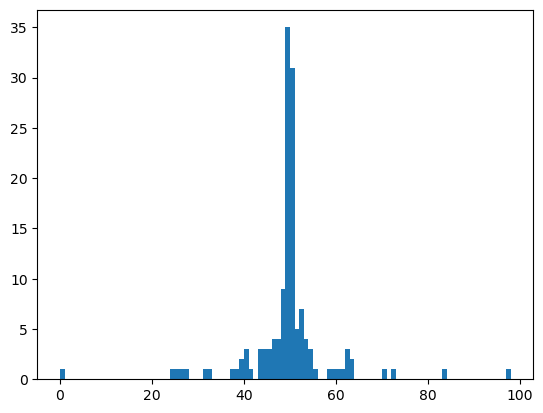

In [22]:
plt.hist(scenarios, bins=np.arange(scenarios.min(), scenarios.max()+1))
plt.show()

In [24]:
def moment_matching(mean, variance, skewness, kurtosis, num_scenarios):
    """
    Generate scenarios by matching the moments of a given distribution.
    
    Args:
        mean (float): Mean of the distribution.
        variance (float): Variance of the distribution.
        skewness (float): Skewness of the distribution.
        kurtosis (float): Kurtosis of the distribution.
        num_scenarios (int): Number of scenarios to generate.

    Returns:
        np.array: Scenarios that match the specified moments.
    """
    standard_normal = np.random.normal(size=num_scenarios)
    scenarios = (
        mean
        + np.sqrt(variance) * standard_normal
        + skewness * (standard_normal ** 2 - 1)
        + kurtosis * (standard_normal ** 3 - 3 * standard_normal)
    )
    
    scenarios = np.clip(scenarios, 0, None)
    
    return scenarios

In [26]:
scenarios = moment_matching(50,100,0,3,140)

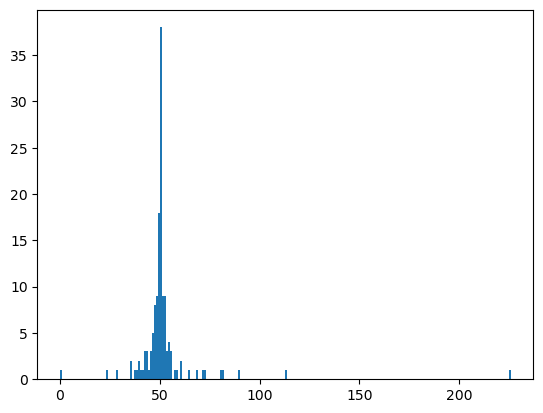

In [28]:
plt.hist(scenarios, bins=np.arange(scenarios.min(), scenarios.max()+1))
plt.show()

In [30]:
target_dist = np.random.normal(loc=50, scale=10, size=2000)  # example target

In [32]:
target_dist

array([51.13517345, 56.62130675, 65.86016816, ..., 38.51205965,
       56.66312501, 54.62591293])

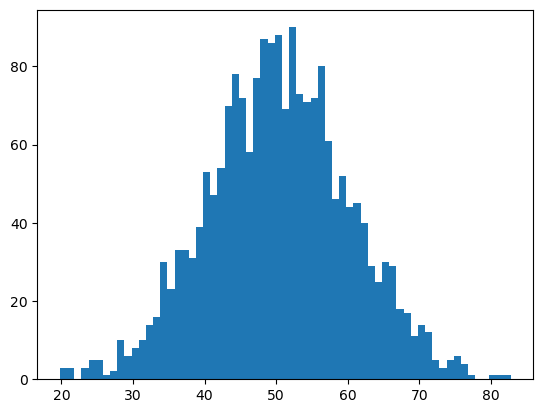

In [34]:
plt.hist(target_dist, bins=np.arange(target_dist.min(), target_dist.max()+1))
plt.show()

In [36]:
for _ in range(100):
    for i in range(len(scenarios)):
        # Propose a small random adjustment
        adjustment = np.random.normal(scale=0.1)
        updated_scenarios = scenarios.copy()
        updated_scenarios[i] += adjustment

        # Accept the update if it improves (lowers) the Wasserstein distance
        if wasserstein_distance(target_dist, updated_scenarios) < \
            wasserstein_distance(target_dist, scenarios):
            scenarios = updated_scenarios

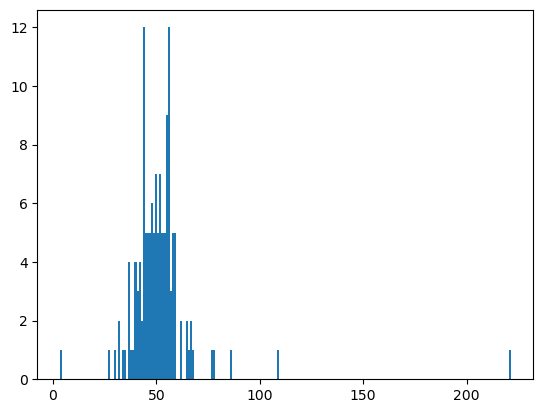

In [37]:
plt.hist(scenarios, bins=np.arange(scenarios.min(), scenarios.max()+1))
plt.show()

In [38]:
def minimize_wasserstein_distance(target_distribution, initial_scenarios, max_iterations=100):
    """
    Naive approach to minimize the Wasserstein distance between generated scenarios 
    and a target distribution, by small random adjustments.

    Args:
        target_distribution (np.array): Target demand (or other) distribution.
        initial_scenarios (np.array): Initial scenarios.
        max_iterations (int): Maximum iterations for optimization.

    Returns:
        np.array: Optimized scenarios.
    """
    current_scenarios = initial_scenarios.copy()
    for _ in range(max_iterations):
        for i in range(len(current_scenarios)):
            # Propose a small random adjustment
            adjustment = np.random.normal(scale=0.1)
            updated_scenarios = current_scenarios.copy()
            updated_scenarios[i] += adjustment

            # Accept the update if it improves (lowers) the Wasserstein distance
            if wasserstein_distance(target_distribution, updated_scenarios) < \
               wasserstein_distance(target_distribution, current_scenarios):
                current_scenarios = updated_scenarios
    return current_scenarios

In [39]:
def generate_advanced_scenarios(mean, variance, skewness, kurtosis,
                                num_scenarios, target_distribution,
                                max_iterations=100):
    """
    Generate advanced scenarios using:
       - Moment matching
       - Wasserstein distance minimization

    Returns:
        np.array of scenario values (e.g., demands).
    """
    # Step 1: Moment Matching
    initial_scenarios = moment_matching(mean, variance, skewness, kurtosis, num_scenarios)

    # Step 2: Wasserstein Distance Minimization
    optimized_scenarios = minimize_wasserstein_distance(target_distribution,
                                                        initial_scenarios,
                                                        max_iterations)
    return optimized_scenarios

In [40]:
scenarios = generate_advanced_scenarios(
        mean=50, variance=100, skewness=0.0, kurtosis=3.0,
        num_scenarios=140,  # Reduced from 200
        target_distribution=target_dist
    )

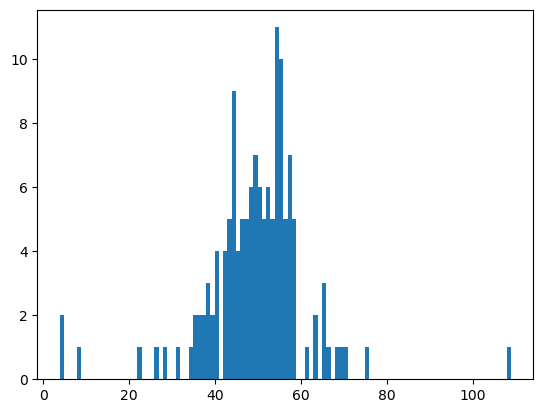

In [45]:
plt.hist(scenarios, bins=np.arange(scenarios.min(), scenarios.max()+1))
plt.show()

In [60]:
base_demands = [100, 150, 200]     # alpha_i
price_sensitivities = [2, 3, 4]  # beta_i

In [47]:
target_distribution = np.random.normal(loc=1.0, scale=0.5, size=1000)
scenario_means = generate_advanced_scenarios(
        mean=50, variance=100, skewness=0.0, kurtosis=3.0,
        num_scenarios=140, target_distribution=target_dist
        )
# Convert them into dicts of (mean, var)
scenarios = []
for m in scenario_means:
    scenarios.append({
    'mean': m,
    'variance': np.random.uniform(0.8, 1.2)  # random scale
})

In [48]:
scenarios

[{'mean': 93.07913737107519, 'variance': 0.8627770906085025},
 {'mean': 46.365594931083045, 'variance': 0.9639137574980875},
 {'mean': 44.812245270446766, 'variance': 0.8619909793263869},
 {'mean': 52.244528043021816, 'variance': 1.1798715459764078},
 {'mean': 44.312528213357254, 'variance': 0.8711029217433817},
 {'mean': 36.22038313905961, 'variance': 0.9676290934201746},
 {'mean': 42.259213546754246, 'variance': 0.832904289183994},
 {'mean': 55.68705672394629, 'variance': 1.1685534087992326},
 {'mean': 48.71356086884613, 'variance': 1.0495275069743204},
 {'mean': 67.97866002065666, 'variance': 1.184982505032419},
 {'mean': 45.846378206063065, 'variance': 0.8169086540887105},
 {'mean': 56.74506480432147, 'variance': 0.8699914035816773},
 {'mean': 54.60833751770053, 'variance': 0.9520195306585452},
 {'mean': 48.228465792560556, 'variance': 1.0485439606382574},
 {'mean': 44.496091042142695, 'variance': 0.9318070692288072},
 {'mean': 31.290348495202064, 'variance': 1.0847496081593562},
 

In [62]:
num_samples = 100
prices = [20,30, 40]
noise_std = 10

# Probabilities for picking each scenario at random
weights = np.ones(len(scenarios))
scenario_prob = weights / weights.sum()
scenario_indices = np.random.choice(len(scenarios), size=num_samples, p=scenario_prob)

num_products = len(prices)
demand_samples = np.zeros((num_samples, num_products))

for i in range(num_products):
    alpha_i = base_demands[i]
    beta_i = price_sensitivities[i]
    p_i = prices[i]

    for j, scenario_idx in enumerate(scenario_indices):
        sc = scenarios[scenario_idx]
        sc_mean = sc['mean']
        sc_std = np.sqrt(sc['variance'])

        scenario_effect = np.random.normal(loc=sc_mean, scale=sc_std)
        noise = np.random.normal(loc=0, scale=noise_std)

        demand_ij = alpha_i - beta_i * p_i + scenario_effect + noise
        # Ensure demand is non-negative (realistic limit)
        demand_samples[j, i] = max(demand_ij, 0)

product_cols = [f"Product_{k+1}" for k in range(num_products)]

In [64]:
df = pd.DataFrame(demand_samples, columns=product_cols)

In [66]:
df

,Product_1,Product_2,Product_3
0,117.383950,91.881881,60.230973
1,111.243682,119.346747,98.900534
2,116.576219,112.585488,97.175133
3,98.985356,99.297152,84.665323
4,95.236796,97.498901,78.667967
...,...,...,...
95,104.149165,109.091669,90.681730
96,120.036264,134.410765,66.610339
97,117.706601,96.828778,93.839518
98,120.368739,103.669189,97.141466


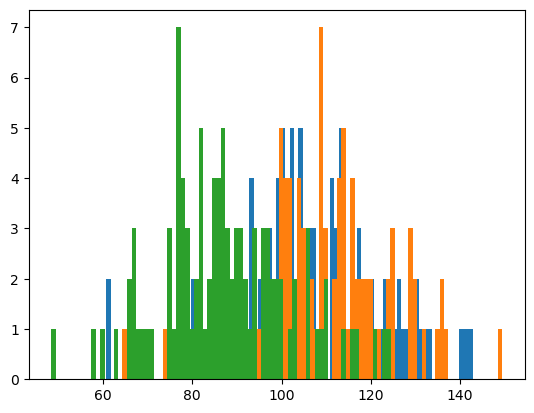

In [72]:
plt.hist(df.Product_1, bins=np.arange(df.Product_1.min(), df.Product_1.max()+1))
plt.hist(df.Product_2, bins=np.arange(df.Product_2.min(), df.Product_2.max()+1))
plt.hist(df.Product_3, bins=np.arange(df.Product_3.min(), df.Product_3.max()+1))

plt.show()

In [76]:
def generate_stochastic_demand_linear(prices, num_samples=1000,
                                      noise_std=5, scenarios=None):
    """
    Generate stochastic demand samples for each product using a simple linear model
    without cross-elasticities. Demand for product i is:

        demand_i = alpha_i - beta_i * price_i + scenario_effect + random_noise

    If no 'scenarios' are provided, we generate them via advanced scenario generation.

    Args:
        prices (list or np.array): Prices of products.
        num_samples (int): Number of demand samples to generate.
        noise_std (float): Std for the additional random noise term.
        scenarios (list of dict or None): 
            If provided, each dict has {'mean', 'variance'}.
            If None, uses default advanced scenario generation.

    Returns:
        pd.DataFrame: Demand samples for each product.
    """
    # Example fixed base demands and price sensitivities
    base_demands = [100, 150, 200]     # alpha_i
    price_sensitivities = [2, 3, 4]  # beta_i

    # If no scenarios provided, create some "fake" advanced scenarios
    if scenarios is None:
        # Example: target distribution for advanced scenario generation
        target_distribution = np.random.normal(loc=1.0, scale=0.5, size=1000)
        # Make 3 advanced scenario means
        scenario_means = generate_advanced_scenarios(
                mean=50, variance=100, skewness=0.0, kurtosis=3.0,
                num_scenarios=140, target_distribution=target_dist
                )
        # Convert them into dicts of (mean, var)
        scenarios = []
        for m in scenario_means:
            scenarios.append({
                'mean': m,
                'variance': np.random.uniform(0.8, 1.2)  # random scale
            })

    # Probabilities for bpicking each scenario at random
    weights = np.ones(len(scenarios))
    scenario_prob = weights / weights.sum()
    scenario_indices = np.random.choice(len(scenarios), size=num_samples, p=scenario_prob)

    num_products = len(prices)
    demand_samples = np.zeros((num_samples, num_products))

    for i in range(num_products):
        alpha_i = base_demands[i]
        beta_i = price_sensitivities[i]
        p_i = prices[i]

        for j, scenario_idx in enumerate(scenario_indices):
            sc = scenarios[scenario_idx]
            sc_mean = sc['mean']
            sc_std = np.sqrt(sc['variance'])

            scenario_effect = np.random.normal(loc=sc_mean, scale=sc_std)
            noise = np.random.normal(loc=0, scale=noise_std)

            demand_ij = alpha_i - beta_i * p_i + scenario_effect + noise
            # Ensure demand is non-negative (realistic limit)
            demand_samples[j, i] = max(demand_ij, 0)

    product_cols = [f"Product_{k+1}" for k in range(num_products)]
    return pd.DataFrame(demand_samples, columns=product_cols)

In [86]:
demand_data = generate_stochastic_demand_linear(prices=prices, num_samples=500, noise_std=10)


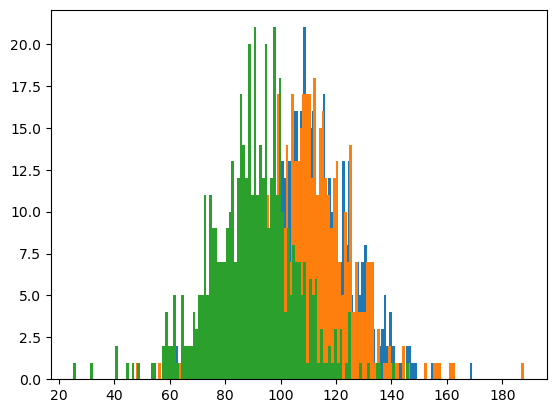

In [87]:
plt.hist(demand_data.Product_1, bins=np.arange(demand_data.Product_1.min(), demand_data.Product_1.max()+1))
plt.hist(demand_data.Product_2, bins=np.arange(demand_data.Product_2.min(), demand_data.Product_2.max()+1))
plt.hist(demand_data.Product_3, bins=np.arange(demand_data.Product_3.min(), demand_data.Product_3.max()+1))
plt.show()

In [88]:
demand_data = generate_stochastic_demand_linear(prices=[30,30, 30], num_samples=500, noise_std=10)


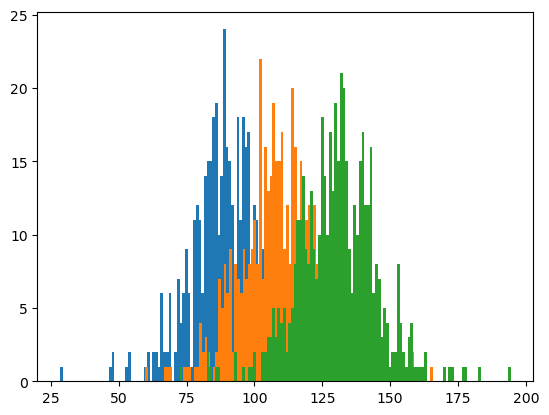

In [89]:
plt.hist(demand_data.Product_1, bins=np.arange(demand_data.Product_1.min(), demand_data.Product_1.max()+1))
plt.hist(demand_data.Product_2, bins=np.arange(demand_data.Product_2.min(), demand_data.Product_2.max()+1))
plt.hist(demand_data.Product_3, bins=np.arange(demand_data.Product_3.min(), demand_data.Product_3.max()+1))

plt.show()

In [90]:
demand_data

,Product_1,Product_2,Product_3
0,127.266244,126.026792,149.168759
1,89.024241,102.522623,116.148128
2,83.353774,93.335923,110.092918
3,72.988622,88.089842,123.495308
4,107.612960,85.789619,116.841453
...,...,...,...
495,77.894230,89.360520,119.239986
496,86.971751,93.733565,125.904859
497,104.002535,112.079316,138.635777
498,107.876817,124.575384,140.712885


In [91]:
import numpy as np
from scipy import stats

In [97]:
def calculate_revenue(demand_data,prices):
    hist_1 = np.histogram(demand_data.Product_1,bins=50)
    dist_1 = stats.rv_histogram(hist_1)
    expected_value_1 = dist_1.expect()
    
    hist_2 = np.histogram(demand_data.Product_2,bins=50)
    dist_2 = stats.rv_histogram(hist_2)
    expected_value_2 = dist_2.expect()

    hist_3 = np.histogram(demand_data.Product_3,bins=50)
    dist_3 = stats.rv_histogram(hist_3)
    expected_value_3 = dist_3.expect()

    expected_value = [expected_value_1.round(),expected_value_2.round(),expected_value_3.round()]
    revenue = np.dot(prices,expected_value)
    return revenue

In [107]:
calculate_revenue(demand_data,prices)

10280.0

In [103]:
import warnings

In [105]:
warnings.filterwarnings('ignore')

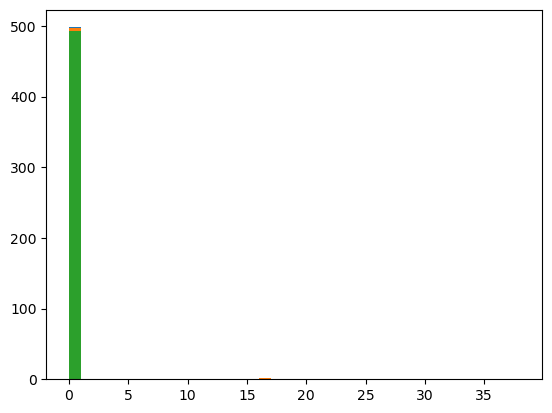

In [109]:
demand_data = generate_stochastic_demand_linear(prices=[100,80,70], num_samples=500, noise_std=10)
plt.hist(demand_data.Product_1, bins=np.arange(demand_data.Product_1.min(), demand_data.Product_1.max()+1))
plt.hist(demand_data.Product_2, bins=np.arange(demand_data.Product_2.min(), demand_data.Product_2.max()+1))
plt.hist(demand_data.Product_3, bins=np.arange(demand_data.Product_3.min(), demand_data.Product_3.max()+1))

plt.show()

90 - 80 when the both dist. of demands are 0 

In [111]:
price_range_1 = np.linspace(20,100,5)
price_range_2 = np.linspace(30,80,5)
price_range_3 = np.linspace(40,70,5)

In [813]:
price_range_1

array([ 20.,  40.,  60.,  80., 100.])

In [815]:
price_range_2

array([30. , 42.5, 55. , 67.5, 80. ])

In [113]:
results = []  # to store [p1, p2, revenue]

for p1 in price_range_1:
    for p2 in price_range_2:
        for p3 in price_range_3:
    
            demand_data = generate_stochastic_demand_linear(prices=[p1, p2, p3], 
                                                            num_samples=500, 
                                                            noise_std=10)
            revenue = calculate_revenue(demand_data, [p1, p2, p3])
            results.append([p1, p2, p3, revenue])

# Create a DataFrame from the collected results
df = pd.DataFrame(results, columns=['p1', 'p2', 'p3' , 'revenue'])

# Optionally display or save df
print(df)

        p1    p2    p3  revenue
0     20.0  30.0  40.0   9100.0
1     20.0  30.0  47.5   8252.5
2     20.0  30.0  55.0   7130.0
3     20.0  30.0  62.5   5895.0
4     20.0  30.0  70.0   5650.0
..     ...   ...   ...      ...
120  100.0  80.0  40.0   3600.0
121  100.0  80.0  47.5   2945.0
122  100.0  80.0  55.0   1650.0
123  100.0  80.0  62.5    580.0
124  100.0  80.0  70.0      0.0

[125 rows x 4 columns]


In [115]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge
from scipy.optimize import minimize

In [131]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

def fit_and_visualize_surface(revenue_df):
    """
    Fits a Linear regression model with polynomial features to the revenue data.
    
    Parameters:
    revenue_df (pd.DataFrame): DataFrame containing 'p1', 'p2', 'p3', and 'revenue' columns.
    
    Returns:
    pipeline (Pipeline): Trained sklearn Pipeline containing preprocessing and regression steps.
    scaler_y (MinMaxScaler): Scaler used for the target variable.
    response_function (function): Function to predict revenue based on p1, p2, and p3.
    """
    
    # Ensure the input DataFrame contains the required columns
    required_columns = {'p1', 'p2', 'p3', 'revenue'}
    if not required_columns.issubset(revenue_df.columns):
        raise ValueError(f"Input DataFrame must contain columns: {required_columns}")
    
    # Features and target
    X = revenue_df[['p1', 'p2', 'p3']]
    y = revenue_df['revenue'].values.reshape(-1, 1)
    
    # Initialize scalers for X and y
    scaler_X = MinMaxScaler(feature_range=(-1, 1))
    scaler_y = MinMaxScaler(feature_range=(-1, 1))
    
    # Define a pipeline for polynomial feature transformation and Linear regression
    pipeline = Pipeline([
        ('scaler_X', scaler_X),
        ('poly', PolynomialFeatures(degree=4, include_bias=False)),
        ('linear_reg', LinearRegression())
    ])
    
    # Fit the scaler for y and transform y
    y_normalized = scaler_y.fit_transform(y).flatten()
    
    # Fit the pipeline with normalized X and y
    pipeline.fit(X, y_normalized)
    
    # Define response function
    def response_function(p1, p2, p3):
        """
        Predicts revenue based on p1, p2, and p3 using the trained model.
        
        Parameters:
        p1 (float or np.ndarray): Value(s) for parameter p1.
        p2 (float or np.ndarray): Value(s) for parameter p2.
        p3 (float or np.ndarray): Value(s) for parameter p3.
        
        Returns:
        revenue_pred (float or np.ndarray): Predicted revenue.
        """
        input_data = np.vstack([p1, p2, p3]).T
        X_scaled = scaler_X.transform(input_data)
        y_pred_normalized = pipeline.named_steps['linear_reg'].predict(
            pipeline.named_steps['poly'].transform(X_scaled)
        )
        revenue_pred = scaler_y.inverse_transform(y_pred_normalized.reshape(-1, 1)).flatten()
        return revenue_pred
    
    return pipeline, scaler_y, response_function


In [133]:
# Call the updated function
pipeline, scaler_y, response_function = fit_and_visualize_surface(df)

In [135]:
from scipy.optimize import minimize

def optimize_prices(response_function, p1_bounds, p2_bounds, p3_bounds):
    """
    Optimize p1, p2, and p3 to maximize revenue using the provided response function.

    Parameters:
    response_function (function): Function that takes p1, p2, and p3 and returns predicted revenue.
    p1_bounds (tuple): (min, max) bounds for p1.
    p2_bounds (tuple): (min, max) bounds for p2.
    p3_bounds (tuple): (min, max) bounds for p3.

    Returns:
    optimal_p1 (float): Optimal value for p1.
    optimal_p2 (float): Optimal value for p2.
    optimal_p3 (float): Optimal value for p3.
    optimal_revenue (float): Predicted revenue at optimal p1, p2, and p3.
    """

    # Define the objective function to minimize (negative revenue)
    objective_function = lambda x: -response_function(x[0], x[1], x[2])

    # Initial guess: midpoint of the bounds for p1, p2, and p3
    initial_guess = [
        (p1_bounds[0] + p1_bounds[1]) / 2,
        (p2_bounds[0] + p2_bounds[1]) / 2,
        (p3_bounds[0] + p3_bounds[1]) / 2
    ]

    # Define bounds for p1, p2, and p3
    bounds = [p1_bounds, p2_bounds, p3_bounds]

    # Perform the optimization
    result = minimize(objective_function, initial_guess, bounds=bounds, method='L-BFGS-B')

    # Check if the optimization was successful
    if not result.success:
        raise ValueError(f"Optimization failed: {result.message}")

    # Extract optimal p1, p2, and p3
    optimal_p1, optimal_p2, optimal_p3 = result.x

    # Compute the optimal revenue using the response function
    optimal_revenue = response_function(optimal_p1, optimal_p2, optimal_p3)

    return optimal_p1, optimal_p2, optimal_p3, optimal_revenue


In [137]:
# Determine the bounds for p1, p2, and p3 based on the data
p1_min, p1_max = df['p1'].min(), df['p1'].max()
p2_min, p2_max = df['p2'].min(), df['p2'].max()
p3_min, p3_max = df['p3'].min(), df['p3'].max()

# Optimize to find the best p1, p2, and p3 values
optimal_p1, optimal_p2, optimal_p3, optimal_revenue = optimize_prices(
    response_function,
    p1_bounds=(p1_min, p1_max),
    p2_bounds=(p2_min, p2_max),
    p3_bounds=(p3_min, p3_max)
)

print(f"Optimal p1: {optimal_p1}")
print(f"Optimal p2: {optimal_p2}")
print(f"Optimal p3: {optimal_p3}")
print(f"Optimal Revenue: {optimal_revenue}")


Optimal p1: 37.723390272145494
Optimal p2: 33.24503045347277
Optimal p3: 40.0
Optimal Revenue: [9790.50183218]


In [139]:
optimal_price_set = [optimal_p1, optimal_p2, optimal_p3]
optimal_demand_data = generate_stochastic_demand_linear(prices=optimal_price_set, num_samples=10000, noise_std=10)
calculate_revenue(optimal_demand_data,optimal_price_set)

9827.002346211662

In [140]:
df.revenue.max()

9700.0

In [141]:
# Calculate the revenue increase
revenue_increase = calculate_revenue(optimal_demand_data, optimal_price_set) - df['revenue'].max()

print(f"Revenue increased by {revenue_increase}")


Revenue increased by 127.00234621166237
